# ROC and PR curves

In [1]:
# import librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
# import data & data preprocessing
df_raw = pd.read_csv('data/titanic.csv')
df = df_raw.copy() 
df = df.dropna(subset = ['Age']) # delete NaN values in Age
df['Sex'].replace(['female','male'],[0,1],inplace=True) # convert categorical data to numerical data
X_train = pd.DataFrame(df, columns = ['Pclass','Sex','Age','SibSp','Parch','Fare'])
Y_train=df['Survived']
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


## Training Data

In [3]:
algorithm = [KNeighborsClassifier(), LogisticRegression(), DecisionTreeClassifier(max_depth=2), 
             BaggingClassifier(), RandomForestClassifier(), AdaBoostClassifier(),
             GradientBoostingClassifier(), XGBClassifier(use_label_encoder=False, eval_metric='logloss')]

models = ['knn', 'lr', 'dt','bag','rf','ab','gb','xgb']

def training(X,Y,algorithm,models):
    clf = {key : algorithm[i].fit(X,Y) for i, key in enumerate(models)} # mapping training process 
    return clf 

def predictions(X,Y,algorithm,models):
    d1 = training(X,Y,algorithm,models)
    for k, v in d1.items():
        d1[k] = v.predict(X) #y_hat
    return d1

def probabilities(X,Y,algorithm,models):
    d2 = training(X,Y,algorithm,models)
    for k, v in d2.items():
        d2[k] = v.predict_proba(X)[:,1] # Confidence Positive
    return d2


## Algorithm for ROC and PR curves

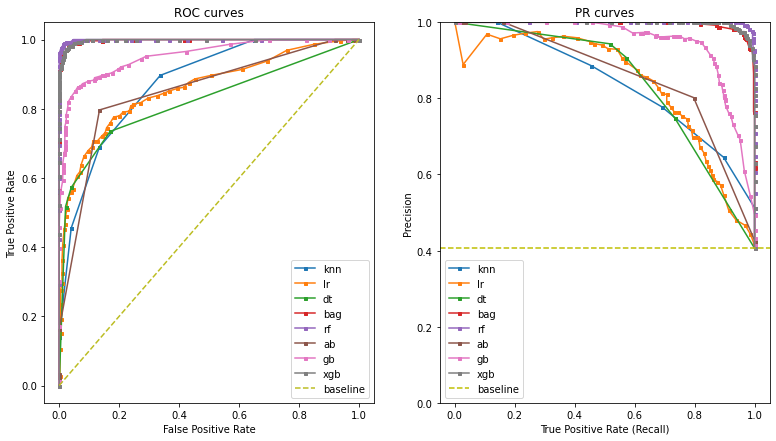

In [4]:
# Algorithm for ROC and PR curves

def calc_TPR_FPR_precision(Y, y_hat):
    y_true=Y # true class series
    y_hat = pd.Series(y_hat, index=y_true.index)
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in y_true.index: 
        if y_true[i]==y_hat[i]==1:
            TP += 1
        if y_true[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==1 and y_true[i]!=y_hat[i]:
            FP += 1
        if y_hat[i]==0 and y_true[i]!=y_hat[i]:
            FN += 1
    
    try:
        precision = TP / (TP + FP)
    except:
        precision = 1 # working convention to evoid 0/0
    
    try:     
        TPR = TP / (TP + FN) # recall
    except:
        TPR = None
    try:
        FPR = FP / (TN + FP)
    except:
        FPR = None

    return precision, TPR, FPR

def coordinates(X,Y,algorithm,models):
    
    precision_collections = []
    TPR_collections = []
    FPR_collections = []
    
    for i, model in enumerate(models):
        
        y_test_probs = probabilities(X,Y,algorithm,models)[model]
        
        # Containers for precision / true positive / false positive rates
        precision_scores = []
        TPR_scores = []
        FPR_scores = []
    
        # Define probability thresholds to use, between 0 and 1
        probability_thresholds = np.linspace(0, 1, num=55)
    
        # Find precision / true positive / false positive rate for each threshold
        for p in probability_thresholds:
            
            y_test_preds = []
    
            for prob in y_test_probs:
                if (prob >= p) and (p < 1): # = and < 1 constraints to evoid missing values in limits 1 and 0 for kNN, Bagging & RF
                    y_test_preds.append(1)
                else:
                    y_test_preds.append(0)
                    
            precision, TPR, FPR = calc_TPR_FPR_precision(Y, y_test_preds)
        
            precision_scores.append(precision)
            TPR_scores.append(TPR)
            FPR_scores.append(FPR)
        precision_collections.append(precision_scores)    
        TPR_collections.append(TPR_scores)
        FPR_collections.append(FPR_scores)
    
    return  np.array(precision_collections), np.array(TPR_collections), np.array(FPR_collections)


def ROC_plot_curve(X,Y,algorithm,models):
    
    c = coordinates(X,Y,algorithm,models)
    
    for i in range(len(models)):
        ROC = plt.plot(c[2][i],c[1][i],'-s',markersize=3, label=models[i])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
    ROCb = plt.plot([0, 1], linestyle='--', label='baseline')
    plt.legend()
    plt.title('ROC curves')
    return ROC, ROCb

def PR_plot_curve(X,Y,algorithm,models):
    
    c = coordinates(X,Y,algorithm,models)
    
    for i in range(len(models)):
        PR = plt.plot(c[1][i],c[0][i],'-s',markersize=3, label=models[i])
        plt.xlabel('True Positive Rate (Recall)')
        plt.ylabel('Precision')
        plt.ylim(0, 1)
        plt.legend()
    bl = sum(Y==1)/(sum(Y==1)+sum(Y==0)) # baseline
    PRb = plt.axhline(y = bl, xmin = 0.0, xmax = 1.0, color ='y', linestyle = '--', label='baseline')
    plt.legend()
    plt.title('PR curves')
    return PR, PRb


plt.figure(figsize=(13,7))
plt.subplot(1,2,1)
ROC_curves = ROC_plot_curve(X_train,Y_train,algorithm,models)
plt.subplot(1,2,2)
PR_curves = PR_plot_curve(X_train,Y_train,algorithm,models)


## AUC metric and comparison table for different metrics

In [5]:
metrics = ['Accuracy','ROC_AUC','Precision','TPR','FPR']

def AUC(X,Y,algorithm,models):
    
    c = coordinates(X,Y,algorithm,models)
    
    ROC_AUC = {model : round(np.trapz(np.flip(c[1][i]),np.flip(c[2][i]))*100, 2) for i, model in enumerate(models)}
    
    return ROC_AUC


def table_metrics(X,Y,algorithm,models,metrics):
    
    clf = training(X,Y,algorithm,models)
    c = coordinates(X,Y,algorithm,models)
    
    for metric in metrics:
        
        if metric == 'Accuracy':
            d1 = {k : round(v.score(X,Y)*100,2) for k,v in clf.items()}
    
        elif metric == 'ROC_AUC':
            d2 = AUC(X,Y,algorithm,models)
    
        elif metric == 'Precision':
            d3 = {k: round(np.mean(c[0][i])*100, 2) for i, k in enumerate(models)}
        
        elif metric == 'TPR':
            d4 = {k: round(np.mean(c[1][i])*100, 2) for i, k in enumerate(models)}
        
        elif metric == 'FPR':
            d5 = {k: round(np.mean(c[2][i])*100, 2) for i, k in enumerate(models)}
            
        
    dic = {'Accuracy': d1, 'ROC_AUC': d2, 'Precision' : d3, 'Recall (TPR)' : d4, 'FPR' : d5} # nested dic
    
    tab = pd.DataFrame(dic).rename_axis("Model", axis="columns")
    
    return tab
    
table_metrics(X_train,Y_train,algorithm,models,metrics)

Model,Accuracy,ROC_AUC,Precision,Recall (TPR),FPR
knn,79.41,87.33,76.24,63.40,23.89
lr,80.25,85.88,75.83,64.28,24.67
dt,80.25,82.05,78.85,63.87,24.23
bag,96.50,99.74,90.91,87.72,9.19
rf,98.60,99.95,91.09,87.22,9.62
ab,83.75,85.01,70.59,51.27,48.91
gb,90.90,95.38,84.62,75.23,17.26
xgb,97.06,99.79,92.14,88.14,8.34


## AUC metric from scikit 

In [6]:
from sklearn.metrics import roc_auc_score

In [7]:
AUC_collections=[]
y_true = Y_train
for model in models:
    y_prob = pd.DataFrame.from_dict(probabilities(X_train,Y_train,algorithm,models))[model]
    output = round(roc_auc_score(y_true,y_prob)*100,2)
    AUC_collections.append(output)
AUC_collections

ROC_AUC_sl = {k : AUC_collections[i] for i, k in enumerate(models)}
ROC_AUC_sl

{'knn': 87.33,
 'lr': 85.89,
 'dt': 82.05,
 'bag': 99.69,
 'rf': 99.93,
 'ab': 89.66,
 'gb': 95.4,
 'xgb': 99.79}